In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# pets 分类

1. fit_one_cycle 中如果单独使用一个数值，那么各层的学习率是一样的，如果使用 slice 则表明使用 discriminative learning rates
2. 输入一个数字（例如1e-3）：每一层都有相同的学习率
3. slice(1e-3)：最后一层使用学习率（1e-3），然后所有其他层使用相同的学习率，即 1e-3/3.所以其他所有层都是1e-3/3。 最后一层将是1e-3。
4. slice(1e-5, 1e-3)。 最后的层（这些随机添加的层）仍将是1e-3。 第一层是1e-5，其他层将获得在这两层之间平均分布的学习率，如果有三层，则会有1e-5,1e-4,1e-3，每次都是相等的倍数。

In [5]:
from fastai.vision import *

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

In [12]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, callback_fns=ShowGraph).to_fp16()

In [ ]:
learn.model

In [ ]:
lg = learn.layer_groups
len(lg)
lg

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


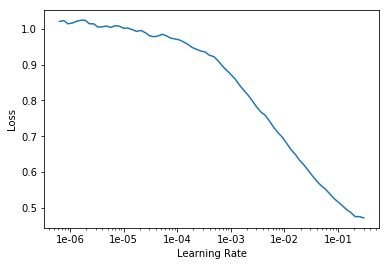

In [7]:
learn.lr_find()
learn.recorder.plot()

In [8]:
lr = 1e-2

In [9]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
ReLU                 [64, 14, 14]         0          False     
______________________________________________________________________
MaxPool2d            [64, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 7, 7]           128        True      
______________________________________________________________________
ReLU                 [64, 7, 7]           0          False     
______________________________________________________________

epoch,train_loss,valid_loss,accuracy,time
0,0.057825,0.038170,0.986752,00:05
1,0.024984,0.007705,0.997056,00:05
2,0.008993,0.006420,0.997056,00:05


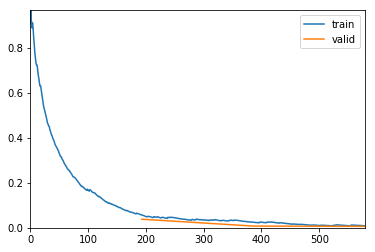

In [10]:
learn.fit_one_cycle(3, lr)

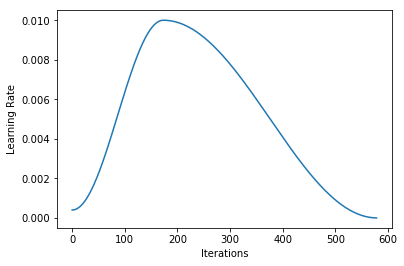

In [11]:
learn.recorder.plot_lr()

In [12]:
learn.unfreeze()

In [13]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
ReLU                 [64, 14, 14]         0          False     
______________________________________________________________________
MaxPool2d            [64, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 7, 7]           128        True      
______________________________________________________________________
ReLU                 [64, 7, 7]           0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


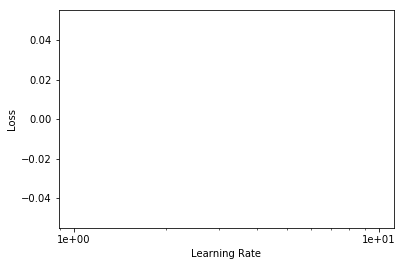

In [14]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.027918,0.004894,0.999019,00:07
1,0.011691,0.002919,0.999509,00:06
2,0.001608,0.001306,0.999509,00:06


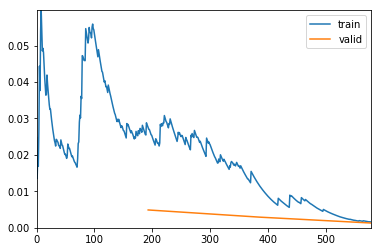

In [15]:
learn.fit_one_cycle(3, slice(1e-2/2.6**4, 1e-2))

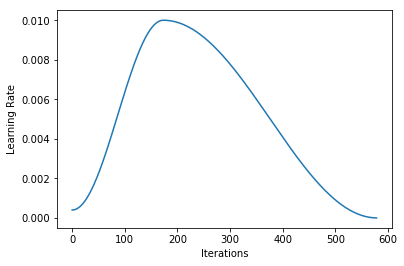

In [16]:
learn.recorder.plot_lr()

## Pets more

In [25]:
root = untar_data(URLs.PETS)
root
root.ls()

PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet')

[PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/annotations')]

In [26]:
img_root = root/'images'
img_root.ls()[:5]

[PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_160.jpg'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images/Bengal_36.jpg'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_40.jpg'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images/american_bulldog_176.jpg'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images/boxer_27.jpg')]

## 数据扩充

In [27]:
tsfm = get_transforms(do_flip=True, max_rotate=20, max_zoom=1.3, max_lighting=0.4,
                      max_warp=0.4, p_affine=1., p_lighting=1.)

In [28]:
src = ImageList.from_folder(img_root).split_by_rand_pct(0.2, seed=2)

- 获取数据，默认使用 镜像 填充
- 正则匹配 内容不含/的一个或者多个字符紧跟着是_然后是1个或多个数字以.jpg结尾，提取的信息是不含/的字符串

In [29]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tsfm, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [30]:
bs = 32

In [31]:
data = get_data(224, bs, 'zeros')

- 黑边是因为是使用 0 填充的

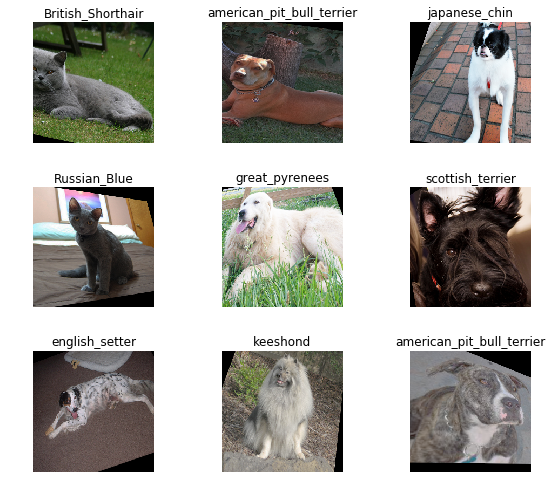

In [32]:
data.show_batch(rows=3, figsize=(8, 7))

In [33]:
data = get_data(224, bs)

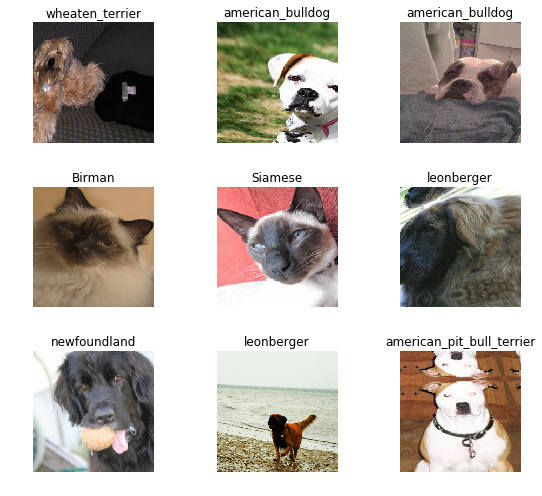

In [34]:
data.show_batch(rows=3, figsize=(8, 7))

In [27]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate], bn_final=True)

14987

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


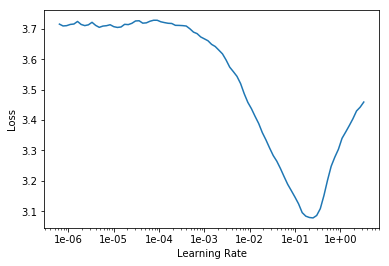

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr = 1e-3

In [30]:
g = learn.layer_groups
len(g)
g

3

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [31]:
# 分段learning rate，使用同樣的lerning rate 效果不好
learn.fit_one_cycle(8, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.357472,3.008184,0.284844,0.715156,00:53
1,2.804896,2.321662,0.552097,0.447903,00:44
2,2.426746,1.869368,0.654939,0.345061,00:51
3,2.125648,1.459900,0.781461,0.218539,00:58
4,1.854396,1.154852,0.866035,0.133965,00:58
5,1.584859,0.890437,0.903248,0.096752,00:46
6,1.395871,0.681640,0.916103,0.083897,00:45
7,1.255875,0.637910,0.918809,0.081191,00:46


In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


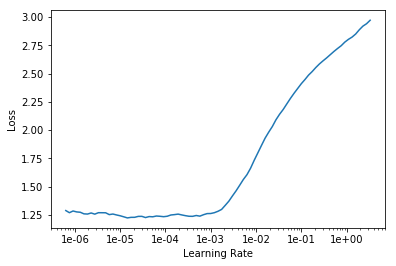

In [33]:
learn.lr_find()
learn.recorder.plot()

In [35]:
lr1 = 1e-4

In [37]:
learn.fit_one_cycle(5, slice(lr1/2.6**3, lr1), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.033902,0.477645,0.938430,0.061570,00:48
1,1.005899,0.486862,0.943843,0.056157,00:49
2,1.010108,0.453799,0.941813,0.058187,00:48
3,0.989659,0.450185,0.938430,0.061570,00:46
4,0.932015,0.427270,0.940460,0.059540,00:45


- 换更大的尺寸

In [38]:
data = get_data(352,bs)
learn.data = data

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


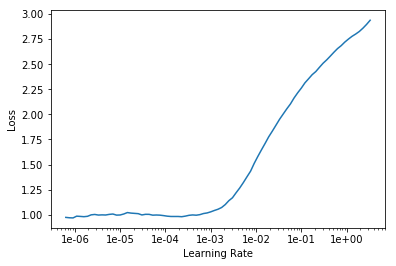

In [42]:
learn.recorder.plot()

In [43]:
lr2 = 1e-4

In [44]:
learn.fit_one_cycle(2, max_lr=slice(lr2/2.6**3, lr2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.960649,0.389656,0.952639,0.047361,01:23
1,0.923649,0.380693,0.951962,0.048038,01:27


In [45]:
learn.save('352stage2_resnet')

## 卷积核

In [47]:
data = get_data(352,bs)

In [49]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352stage2_resnet')

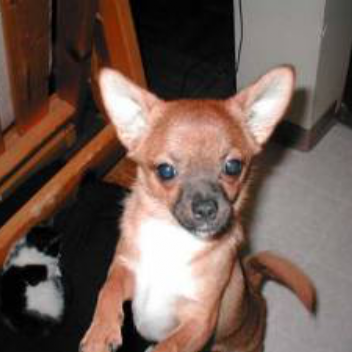

Category chihuahua

In [55]:
x, y = data.valid_ds[0]
x
y

In [59]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [60]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [61]:
k.shape

torch.Size([1, 3, 3, 3])

In [62]:
x.shape

torch.Size([3, 352, 352])

In [70]:
x.data[None].shape

torch.Size([1, 3, 352, 352])

In [71]:
edge = F.conv2d(x.data[None], k)
edge

tensor([[[[ 0.0279, -0.0662, -0.0479,  ..., -0.0035, -0.0100, -0.0171],
          [ 0.0136, -0.0574, -0.0432,  ..., -0.0035, -0.0100, -0.0171],
          [ 0.0034, -0.0384, -0.0295,  ..., -0.0035, -0.0100, -0.0171],
          ...,
          [ 0.0001,  0.0023,  0.0024,  ..., -0.0118, -0.0116, -0.0127],
          [ 0.0003,  0.0045,  0.0054,  ..., -0.0091, -0.0119, -0.0121],
          [ 0.0006,  0.0069,  0.0094,  ..., -0.0100, -0.0130, -0.0093]]]])

In [72]:
edge.shape

torch.Size([1, 1, 350, 350])

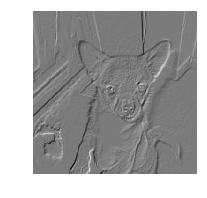

In [75]:
show_image(edge[0])

In [76]:
data.c

37

In [78]:
data.classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

## se_resnet152 模型

In [1]:
import pretrainedmodels
from fastai.vision import *

In [2]:
arch = 'se_resnet152'

In [3]:
def se_resnet152(pretrained=True):
    model = pretrainedmodels.__dict__[arch]()
    return model

### pets more 数据集

In [4]:
tsfm = get_transforms(do_flip=True, max_rotate=20, max_zoom=1.3, max_lighting=0.4,
                      max_warp=0.4, p_affine=1., p_lighting=1.)

In [5]:
root = untar_data(URLs.PETS)
img_root=root/'images'

In [6]:
src = ImageList.from_folder(img_root).split_by_rand_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tsfm, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
bs= 16
size=224

In [9]:
data = get_data(224, bs, 'zeros')

### 学习器构建

In [10]:
learn = cnn_learner(data, base_arch=se_resnet152, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


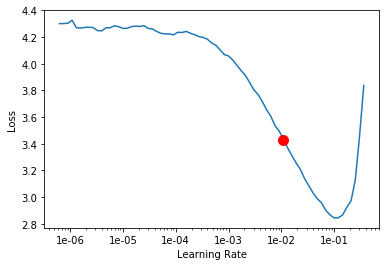

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [12]:
lr=1e-2

In [13]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.966501,0.507291,0.839648,0.160352,02:11
1,0.795729,0.340473,0.885656,0.114344,02:02
2,0.652162,0.252962,0.916779,0.083221,02:03
3,0.472705,0.358907,0.933018,0.066982,02:03
4,0.358455,0.197140,0.931664,0.068336,02:03


In [23]:
learn.save('s1')

In [12]:
learn.load('s1');

In [13]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


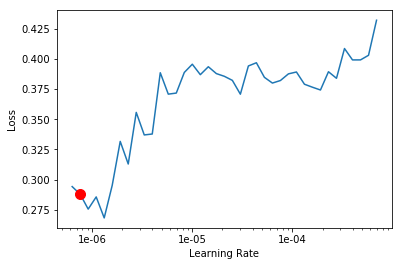

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (se_module

In [17]:
len(learn.layer_groups)

2

In [18]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________

In [15]:
lr1 = 1e-6

In [16]:
learn.fit_one_cycle(5, slice(lr1/2.6**2, lr1))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.402887,0.178087,0.936401,0.063599,02:45
1,0.312811,0.285436,0.938430,0.061570,02:51
2,0.353964,0.414192,0.931664,0.068336,02:46
3,0.348782,0.195226,0.939784,0.060217,02:45
4,0.327802,0.180498,0.937754,0.062246,02:45


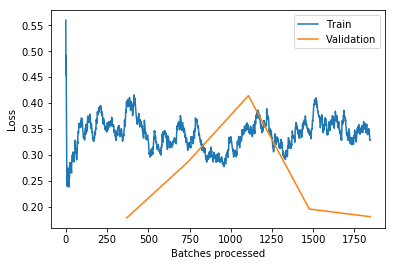

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.export()